In [1]:
from root.src.datasets import ThingsMEGDataset, ImageDataset
from torchvision import transforms
import torch

transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# val_set = ImageDataset("val", "/root/data", transform=transform)

In [2]:
import matplotlib.pyplot as plt

In [ ]:
import os
split ="val"
data_dir = "/root/data"
path = "/root/data/train_image_paths.txt"
# テキストファイルを1行ずつ読む
with open(path, "r") as f:
    # 最後の改行を削除
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]

for i, line in enumerate(lines):
    if "/" not in line:
        # lineの一番最後の_より前の文字を取得
        last_underscore_index = line.rfind('_')
        if last_underscore_index != -1:
            line = f"{line[:last_underscore_index]}/{line}"
        lines[i] = line
lines

In [10]:
from PIL import Image
image = Image.open(f"/root/data/Images/{lines[0]}")
image = transform(image)
image.shape

torch.Size([3, 224, 224])

In [4]:
from torchvision import models
# 学習済みの重みを使用
use_pretrained = True

# モデルをロード
net = models.efficientnet_v2_l(pretrained=use_pretrained)
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:20<00:00, 23.6MB/s]  


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
for X, y in val_set:
    print(X.shape)
    print(y)
    break

torch.Size([3, 224, 224])
tensor(1820)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


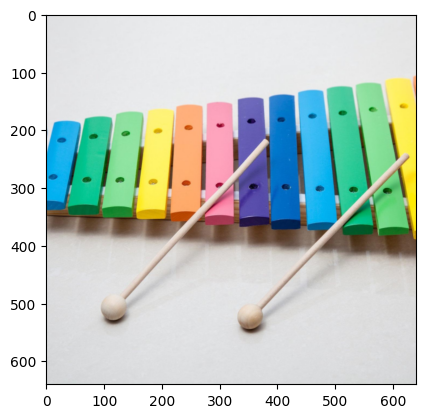

In [5]:
plt.imshow(val_set.X[150].permute(1, 2, 0))

In [7]:
import torch.nn.functional as F
import torch.nn as nn
import torch

class CLIPLoss(nn.Module):
    def __init__(self, temperature=1) -> None:
        super().__init__()
        self.temperature = temperature

    def forward(self, encoded_image: torch.Tensor, encoded_meg: torch.Tensor) -> torch.Tensor:
        # Normalize the embeddings
        encoded_image = F.normalize(encoded_image, dim=-1)
        encoded_meg = F.normalize(encoded_meg, dim=-1)
        
        logits = torch.matmul(encoded_image, encoded_meg.T) * torch.exp(self.temperature)

        # symmetric loss function
        labels = torch.arange(logits.shape[0])
        loss_i = F.cross_entropy(logits, labels, axis=0)
        loss_t = F.cross_entropy(logits, labels, axis=1)
        loss = (loss_i + loss_t)/2
        
        return loss

In [33]:
def create_label_matrix(y: torch.Tensor) -> torch.Tensor:
    # Create a zero matrix of shape (batch_size, batch_size)
    label_matrix = torch.eye((y.size(0)))
    
    # Set the appropriate elements to 1
    for i in range(y.size(0)):
        for j in range(i+1, y.size(0)):
            if y[i] == y[j]:
                label_matrix[i, j] = 1
                label_matrix[j, i] = 1
    return label_matrix

In [58]:
y = torch.randint(1, 5, (3,))
target = create_label_matrix(y)
print(y)
print(target)

tensor([2, 2, 3])
tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])


In [59]:
import torch.nn.functional as F
input = torch.tensor([[0.8, 0.2, 0.2], [0.5, 0.5, 0.1], [0.2, 0.2, 0.6]])
loss = F.binary_cross_entropy(input, target)
print(loss)

tensor(0.5005)


In [60]:
def cross_entropy_loss(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    # Vectorized cross entropy loss
    loss = -(labels * torch.log(logits) + (1 - labels) * torch.log(1 - logits))
    return loss.sum()

In [61]:
loss = 0
loss_1 = 0
for i in range(3):
    print(input[i])
    print(target[i])
    for j in range(3):
        loss_1 += -(target[i][j] * torch.log(input[i][j]) + (1 - target[i][j]) * torch.log(1 - input[i][j]))
print(loss)
print(loss_1)
print(cross_entropy_loss(input, target))

tensor([0.8000, 0.2000, 0.2000])
tensor([1., 1., 0.])
tensor([0.5000, 0.5000, 0.1000])
tensor([1., 1., 0.])
tensor([0.2000, 0.2000, 0.6000])
tensor([0., 0., 1.])
0
tensor(4.5045)
tensor(4.5045)


In [45]:
def create_label_matrix2(y: torch.Tensor) -> torch.Tensor:
    # Create a zero matrix of shape (batch_size, batch_size)
    label_matrix = torch.eye(y.size(0), device=y.device)
    
    # Set the appropriate elements to 1
    y = y.unsqueeze(0)
    label_matrix = (y == y.T).float()
    return label_matrix

In [50]:
y = torch.randint(1, 5, (3,))
target = create_label_matrix(y)
target2 = create_label_matrix2(y)
print(y)
print(target)
print(target2)

tensor([1, 1, 4])
tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])
tensor([[1., 1., 0.],
        [1., 1., 0.],
        [0., 0., 1.]])


In [65]:
logits = torch.tensor([[0.8, 0.2, 0.2], [0.5, 0.5, 0.1], [0.2, 0.2, 0.6]])
labels = torch.tensor([[0, 1], 0, 1])
loss_i = F.cross_entropy(logits.transpose(0, 1), labels)
print(loss_i)

TypeError: not a sequence

In [24]:
import torch
from torch.utils.data import Sampler, DataLoader
import random
from collections import defaultdict
from root.src.datasets import ImageMEGDataset
from torch.utils.data import DataLoader
from torchvision import transforms

class RandomClassBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.y = dataset.y  # assuming dataset has a 'targets' attribute for labels
        
        # クラスごとにインデックスをまとめる
        self.class_indices = defaultdict(list)
        for idx, label in enumerate(self.y):
            self.class_indices[label.item()].append(idx)

    def __iter__(self):
        # クラスごとのインデックスリストをシャッフル
        for label in self.class_indices:
            random.shuffle(self.class_indices[label])
            
        unique_labels = list(self.class_indices.keys())
        random.shuffle(unique_labels)
        
        batches = []
        
        while len(unique_labels) >= self.batch_size:
            selected_labels = random.sample(unique_labels, self.batch_size)
            batch = []
            
            for label in selected_labels:
                if self.class_indices[label]:
                    batch.append(self.class_indices[label].pop(0))
                    # インデックスを使い切ったらそのラベルをリストから削除
                    if not self.class_indices[label]:
                        unique_labels.remove(label)

            if len(batch) == self.batch_size:
                batches.append(batch)

        return iter(batches)

    def __len__(self):
        return len(self.dataset) // self.batch_size

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ------------------
#    Dataloader
# ------------------
loader_args = {"batch_size": 128, "num_workers": 4}

print("* data loading")
val_set = ImageMEGDataset("val", "/root/data", transform=transform)
batch_size = 128


* data loading


In [26]:
from tqdm import tqdm
sampler = RandomClassBatchSampler(val_set, batch_size)
data_loader = DataLoader(val_set, batch_sampler=sampler)

# データローダーを使ってバッチを取得
for image, meg, subject_idxs, y in tqdm(data_loader):
    i = 2


  0%|          | 0/128 [00:00<?, ?it/s]

 41%|████▏     | 53/128 [01:36<02:16,  1.82s/it]

In [ ]:
from root.src.datasets import ImageMEGDataset
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ------------------
#    Dataloader
# ------------------
loader_args = {"batch_size": 128, "num_workers": 4}

print("* data loading")
train_set = ImageMEGDataset("train", "/root/data", transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, pin_memory=True, **loader_args)
val_set = ImageMEGDataset("val", "/root/data", transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, pin_memory=True, **loader_args)